# Active Noise Cancellation - Simulation


## Introducción
introduccir del TP la explicación de ANC

## Objetivo y alcance
Para este proyecto vamos a realizar la simulación de un sistema de control de audio para llevar a cabo la cancelación activa de ruido. Para realizar este desarrollo vamos a implementar los conceptos estudiados en la materia de Teoría de control, dictada por la Universidad Tecnologica Nacional.
El objetivo principal va a ser lograr obtener las ondas senoidales de sonidos opuestas de distintos ruidos ambientes, estos sonidos ambientes los vamos a obtener de un dataset de acceso público.  
Al realizar este proyecto nos vamos a encontrar con ciertas limitantes que van a acotar el alcance del proyecto. A continuación se listan los puntos limitantes que dan lugar al alcance del trabajo:

## Implementación

#### Entrada
Lo primero que vamos a realizar, va a ser generar una entrada la cual va a ser la salida esperada de nuestro sistema. Luego a esta entrada vamos a introducir las señales captadas por el microfono de sonido ambiente, que generarán ruido en nuestras ondas de sonido de entrada.

Reproducción de sonido simulado. Enter para finalizar


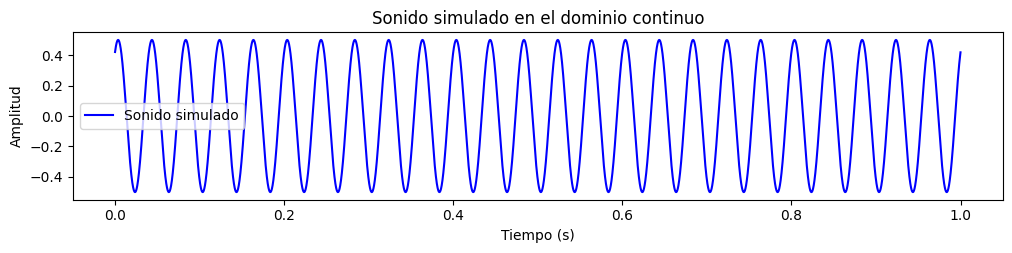

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
import time
import sounddevice as sd

# Duración de reproducción para cada sonido
duracion_reproduccion = 2  # en segundos

# Configuración de la simulación
fs = 20000  # Frecuencia de muestreo en Hz
duration = 1  # Duración en segundos (ajusta según sea necesario)
t_continuo = np.linspace(0, duration, int(fs * duration), endpoint=False)  # Vector de tiempo continuo

# Parámetros del sonido constante simulado
frecuencia_simulado = 25  # Frecuencia del sonido en Hz
amplitud_simulado = 0.5  # Amplitud del sonido simulado (ajusta según sea necesario)
fase_simulado = 1  # Fase del sonido

# Generar sonido constante simulado
sonido_simulado = amplitud_simulado * np.sin(2 * np.pi * frecuencia_simulado * t_continuo + fase_simulado)

# Visualizar las señales de manera continua
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t_continuo, sonido_simulado, label='Sonido simulado', color='b')
plt.title('Sonido simulado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Reproducir sonido simulado
print("Reproducción de sonido simulado. Enter para finalizar")
sd.play(sonido_simulado, fs)
time.sleep(duracion_reproduccion)

#### Medición
Para realizar un sistema de lazo cerrado va a ser fundamental tener un flujo de realimentación, a este flujo de realimentación vamos a agregar un elemento de medición que va a ser en este caso un microfono que escuche la salida de audio del sistema. Para este caso vamos a realizar una simulación de la salida general del sistema, lo que vamos a hacer va a ser obtener mediante el microfono de la computadora una muestra de sonido ambiente, que nos servirá para adicionarla a la onda senoidal simulada para simular la salida con ruido.  
Para realizar la muestra de sonido ambiente vamos a utilizar la biblioteca sounddevice. Una vez obtenida la muestra vamos a mezclar ambos sonidos y reproducirlos tanto analogica como graficamente.

Capturando sonido ambiente durante 1 segundos. Presiona Enter cuando hayas terminado.


Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.


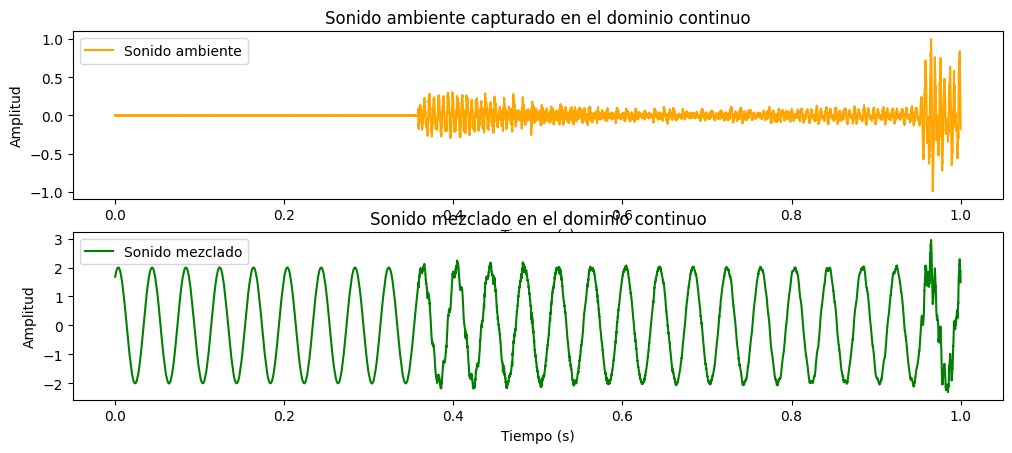

In [6]:
import sounddevice as sd

# Capturar sonido ambiente durante la duración especificada
print(f"Capturando sonido ambiente durante {duration} segundos. Presiona Enter cuando hayas terminado.")
sonido_ambiente = sd.rec(int(fs * duration), samplerate=fs, channels=1, dtype=np.float32)
input()

# Detener la grabación
sd.stop()

# Normalizar las señales
sonido_simulado /= np.max(np.abs(sonido_simulado))
sonido_ambiente[:, 0] /= np.max(np.abs(sonido_ambiente[:, 0]))

# Ajustar la amplitud del sonido simulado
sonido_simulado *= 2.0

# Mezclar las dos señales
sonido_mezclado = sonido_simulado + sonido_ambiente[:, 0]

# Reproducir sonido mezclado
print("Reproduciendo sonido mezclado. Presiona Enter cuando hayas terminado.")
sd.play(sonido_mezclado, fs)

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 2)
plt.plot(t_continuo, sonido_ambiente[:, 0], label='Sonido ambiente', color='orange')
plt.title('Sonido ambiente capturado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(t_continuo, sonido_mezclado, label='Sonido mezclado', color='g')
plt.title('Sonido mezclado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

#### Punto suma
Para el punto suma del sistema, que va a realizar la señal de error entre la entrada y la realimentación, va a ser en parte nuestro algoritmo de filtrado adaptativo "LMS".  
El algoritmo LMS es un algoritmo adaptativo que se utiliza para ajustar un filtro en tiempo real para minimizar el error cuadrático medio entre la salida deseada y la salida real del sistema. Lo vamos a utilizar para obtener un filtro que nos va a permitir obtener una señal de error, que va a ser necesaria para poder definir como realizar la cancelación de sonido.

In [7]:
import numpy as np
from scipy.signal import lfilter

# Implementar un filtro adaptativo LMS para cancelación de sonido
mu = 0.01  # Tasa de aprendizaje del filtro LMS
order = 32  # Orden del filtro

# Inicializar el filtro LMS
filtro_lms = np.zeros(order)

# Aplicar filtro LMS a la señal mezclada
for i in range(order, len(sonido_mezclado)):
    x = sonido_mezclado[i-order:i]
    y_estimado = np.dot(x, filtro_lms)
    error = sonido_mezclado[i] - y_estimado
    filtro_lms = filtro_lms + mu * error * x

# Filtrar la señal mezclada con el filtro LMS aprendido
sonido_cancelado = lfilter(filtro_lms, 1, sonido_mezclado)

#### Controlador
Definir la parte del controlador. 

#### Salida
Para la salida vamos a aplicar el filtro de cancelación de ruido que obtuvimos anteriormente. Una vez hecho esto vamos a tener una nueva onda senoidal definida para el sonido cancelado, que va a ser la mezcla del sonido simulado y el sonido ambiente, pero intentando reducir al máximo posible las ondas de ruido. 

Reproducción de sonido cancelado.


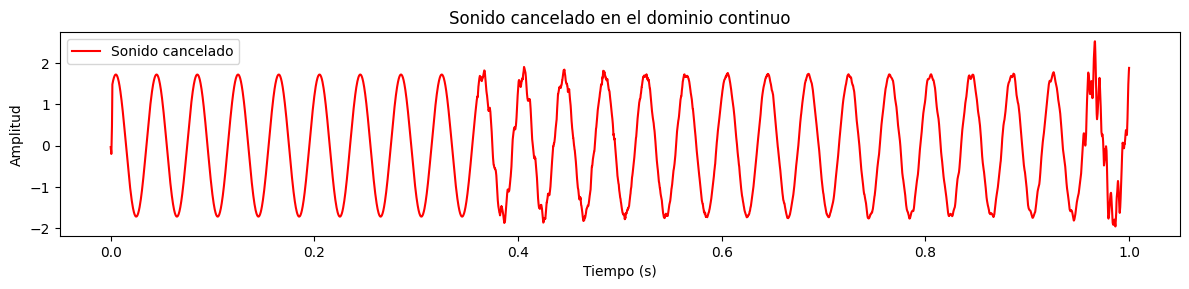

In [9]:
# Visualizar las señales de manera continua
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 4)
plt.plot(t_continuo, sonido_cancelado, label='Sonido cancelado', color='r')
plt.title('Sonido cancelado en el dominio continuo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()

# Reproducir sonido mezclado
print("Reproducción de sonido cancelado.")
sd.play(sonido_mezclado, fs)

plt.tight_layout()
plt.show()